In [0]:
# from google.colab import drive 
# drive.mount('/content/gdrive')
import numpy as np
import pandas as pd
from scipy import stats
from datetime import timedelta
from itertools import product
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
# MERGE_TABLE_STORE_4600 = pd.read_csv('/content/gdrive/My Drive/A Reinforcement Learning Approach for Inventory Optimization in Retail/MERGE_TABLE_STORE_4600/MERGE_TABLE_STORE_4600.csv', sep=';', decimal='.')
# MERGE_TABLE_STORE_4600['Timestamp'] = pd.to_datetime(MERGE_TABLE_STORE_4600['curr_date'], format='%d%b%Y')
# MERGE_TABLE_STORE_4600['curr_date'] = MERGE_TABLE_STORE_4600['Timestamp']
# ss_data = MERGE_TABLE_STORE_4600.set_index(['Timestamp'], drop=True)

# sl_data = pd.read_csv('/content/gdrive/My Drive/A Reinforcement Learning Approach for Inventory Optimization in Retail/MERGE_TABLE_STORE_4600/data/echelon/echelon_1_sl.csv', sep=';')
# sl_data['date_from'] = pd.to_datetime(sl_data['date_from'], format='%d%b%Y')
# sl_data['date_to'] = pd.to_datetime(sl_data['date_to'], format='%d%b%Y')

# empty_states = pd.read_csv('/content/gdrive/My Drive/A Reinforcement Learning Approach for Inventory Optimization in Retail/MERGE_TABLE_STORE_4600/empty_states.csv', index_col=0)
# not_empty_states = pd.read_csv('/content/gdrive/My Drive/A Reinforcement Learning Approach for Inventory Optimization in Retail/MERGE_TABLE_STORE_4600/not_empty_states.csv', index_col=0)
# demand_data = pd.read_csv('/content/gdrive/My Drive/A Reinforcement Learning Approach for Inventory Optimization in Retail/MERGE_TABLE_STORE_4600/demand_data.csv', index_col=0)

# empty_states_train = pd.read_csv('/content/gdrive/My Drive/A Reinforcement Learning Approach for Inventory Optimization in Retail/MERGE_TABLE_STORE_4600/empty_states_train.csv', index_col=0)
# not_empty_states_train = pd.read_csv('/content/gdrive/My Drive/A Reinforcement Learning Approach for Inventory Optimization in Retail/MERGE_TABLE_STORE_4600/not_empty_states_train.csv', index_col=0)
# demand_data_train = pd.read_csv('/content/gdrive/My Drive/A Reinforcement Learning Approach for Inventory Optimization in Retail/MERGE_TABLE_STORE_4600/demand_data_train.csv', index_col=0)

MERGE_TABLE_STORE_4600 = pd.read_csv('/Users/fritzwilliams/Desktop/A Reinforcement Learning Approach for Inventory Optimization in Retail/MERGE_TABLE_STORE_4600.csv', sep=';', decimal='.')
MERGE_TABLE_STORE_4600['Timestamp'] = pd.to_datetime(MERGE_TABLE_STORE_4600['curr_date'], format='%d%b%Y')
MERGE_TABLE_STORE_4600['curr_date'] = MERGE_TABLE_STORE_4600['Timestamp']
ss_data = MERGE_TABLE_STORE_4600.set_index(['Timestamp'], drop=True)

sl_data = pd.read_csv('/Users/fritzwilliams/Desktop/A Reinforcement Learning Approach for Inventory Optimization in Retail/echelon_1_sl.csv', sep=';')
sl_data['date_from'] = pd.to_datetime(sl_data['date_from'], format='%d%b%Y')
sl_data['date_to'] = pd.to_datetime(sl_data['date_to'], format='%d%b%Y')

empty_states = pd.read_csv('/Users/fritzwilliams/Desktop/A Reinforcement Learning Approach for Inventory Optimization in Retail/empty_states.csv', index_col=0)
not_empty_states = pd.read_csv('/Users/fritzwilliams/Desktop/A Reinforcement Learning Approach for Inventory Optimization in Retail/not_empty_states.csv', index_col=0)
demand_data = pd.read_csv('/Users/fritzwilliams/Desktop/A Reinforcement Learning Approach for Inventory Optimization in Retail/demand_data.csv', index_col=0)

empty_states_train = pd.read_csv('/Users/fritzwilliams/Desktop/A Reinforcement Learning Approach for Inventory Optimization in Retail/empty_states_train.csv', index_col=0)
not_empty_states_train = pd.read_csv('/Users/fritzwilliams/Desktop/A Reinforcement Learning Approach for Inventory Optimization in Retail/not_empty_states_train.csv', index_col=0)
demand_data_train = pd.read_csv('/Users/fritzwilliams/Desktop/A Reinforcement Learning Approach for Inventory Optimization in Retail/demand_data_train.csv', index_col=0)

In [0]:
class SMART:
    def __init__(self, ss_data=None, sl_data=None, demand_data=None, pairs_data=None, max_steps=10, lt=1, alpha_order=0.3, alpha=0.01, probability=0.7):
        self.ss_data = ss_data
        self.sl_data = sl_data
        self.demand_data = demand_data
        self.pairs_data = pairs_data
        self.max_steps = max_steps
        self.lt = lt
        self.alpha_order = alpha_order
        self.alpha = alpha
        self.probability = probability

    def load_ss_data(self, data):
        """
        Loads sales and stock data.

        Parameters
        ----------
        data : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples
            and n_features is the number of features
            {product_id, store_id, curr_date, s_qty, flg_spromo, stock, Timestamp}.

        Returns
        -------
        self
        """
        self.ss_data = data
        return self

    def load_sl_data(self, data):
        """
        Loads service level data.

        Parameters
        ----------
        data : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples
            and n_features is the number of features
            {date_from, date_to, product_ids, location_ids, value}.

        Returns
        -------
        self
        """
        self.sl_data = data
        return self

    def load_demand_data(self, data):
        """
        Loads demand data.

        Parameters
        ----------
        data : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples and
            n_features is the number of features
            {shop_id, product_id, lambda, demand}.

        Returns
        -------
        self
        """
        self.demand_data = data
        return self

    def load_pairs_data(self, data):
        """
        Loads data of location-sku pairs with which SMART will work.

        Parameters
        ----------
        data : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples and
            n_features is the number of features {shop_id, product_id}.

        Returns
        -------
        self
        """
        self.pairs_data = data
        return self

    def initial_state(self, shop_id, product_id):
        """
        Initializes a dataframe of initial states for a given location-sku pair.

        Parameters
        ----------
        shop_id : int
        
        product_id : int

        Returns
        -------
        state : {array-like, sparse matrix} of shape (n_samples, n_features)
            Returns the dataframe of the initial states,
            where n_samples is the number of samples and
            n_features is the number of features
            {location, sku, sales, stock, sl, order}.
        """
        state = pd.DataFrame(columns=['location', 'sku', 'sales', 'stock', 'sl', 'order'])

        store_sales_t = self.ss_data[self.ss_data['store_id']==shop_id]
        store_sales_t = store_sales_t[store_sales_t['product_id']==product_id].fillna(0)
        store_sales_t = store_sales_t.drop(columns=['curr_date', 'flg_spromo'])

        sl_data_t = self.sl_data.set_index(['date_from'], drop=True)
        sl_data_t = sl_data_t[sl_data_t['location_ids']==shop_id]
        sl_data_t = sl_data_t[sl_data_t['product_ids']==product_id]

        if not sl_data_t.empty:
            all_days = pd.date_range(start=sl_data_t.index.min(), end=sl_data_t['date_to'].max())
            sl_data_t.index = pd.DatetimeIndex(sl_data_t.index)
            sl_data_t = sl_data_t.reindex(all_days, method='ffill')
            sl_data_t = sl_data_t.drop(columns=['date_to'])

            state_t = pd.merge(store_sales_t, sl_data_t['value'], how='right', left_on=store_sales_t.index, right_on=sl_data_t.index)
            state_t = state_t.rename(columns={'store_id': 'location', 'product_id': 'sku', 's_qty': 'sales', 'value': 'sl'})
            state_t = state_t.drop(columns=['key_0'])
            state_t = state_t.drop_duplicates()
            state_t = state_t.dropna()
            state_t['order'] = 0
            state = state.append(state_t, ignore_index=True)
        return state

    def product_condition(self, state_range, OUL, ROL):
        """
        Computes a list of tuples consisting of all triples
        (state number, OUL, ROL), where OUL > ROL.

        Parameters
        ----------
        state_range : array-like
            Array of state indices for which we want to initialize actions.

        OUL : array-like
            Array of Order Upto Level values.
        
        ROL : array-like
            Array of Re-Order Level values.

        Returns
        -------
        action : array-like
            Returns the list of tuples consisting of all triples.
        """
        prods = []
        for prod in list(product(state_range, OUL, ROL)):
            if prod[1] > prod[2]:
                prods.append(prod)
        return prods

    def initial_action(self, shop_id, product_id, state_range):
        """
        Initializes a dataframe of actions for a given location-sku pair and range of its state indices.

        Parameters
        ----------
        shop_id : int
        
        product_id : int

        state_range : array-like
            Array of state indices for which we want to initialize actions.

        Returns
        -------
        action : {array-like, sparse matrix} of shape (n_samples, n_features)
            Returns the dataframe of the initial actions,
            where n_samples is the number of samples and
            n_features is the number of features {location, sku, state, OUL, ROL, R}.
        """
        action = pd.DataFrame(columns=['location', 'sku', 'state', 'OUL', 'ROL'])

        max_demand = int(self.demand_data[(self.demand_data['product_id'] == product_id) & (self.demand_data['shop_id'] == shop_id)].iloc[0].demand)
        OUL = [i for i in range(max_demand + 1)]
        ROL = [i for i in range(max(OUL))]
        
        action_t = pd.DataFrame(self.product_condition(state_range, OUL, ROL), columns=['state', 'OUL', 'ROL'])
        action = pd.merge(action, action_t, how='outer')
        values = {'location': shop_id, 'sku': product_id}
        action = action.fillna(value=values)
        action['R'] = 0.0
        return action

    def calculate_states(self, actions_per_state=True):
        """
        From self.ss_data and self.sl_data computes dataframes of location-sku pairs,
        information about which is available to initialize states
        and information about which is missing.

        Parameters
        ----------
        actions_per_state : boolean
            If True then compute a quantity of actions per state. Otherwise no.

        Returns
        -------
        not_empty_states : {array-like, sparse matrix} of shape (n_samples, n_features)
            Returns the dataframe of the not empty states pairs,
            where n_samples is the number of samples and
            n_features is the number of features
            {shop_id, product_id, actions_per_state}.

        empty_states : {array-like, sparse matrix} of shape (n_samples, n_features)
            Returns the dataframe of the empty states pairs,
            where n_samples is the number of samples and
            n_features is the number of features
            {shop_id, product_id}.
        """
        shops_ss = np.sort(self.ss_data['store_id'].unique())
        products_ss = np.sort(self.ss_data['product_id'].unique())

        shops_sl = np.sort(self.sl_data['location_ids'].unique())
        products_sl = np.sort(self.sl_data['product_ids'].unique())
        
        empty_states = pd.DataFrame(columns=['shop_id', 'product_id'])
        if actions_per_state:
            not_empty_states = pd.DataFrame(columns=['shop_id', 'product_id', 'actions_per_state'])
            for shop_id in [shop for shop in shops_ss if shop in shops_sl]:
                for product_id in [prod for prod in products_ss if prod in products_sl]:
                    state = self.initial_state(shop_id, product_id)
                    if state.empty:
                        empty_states = empty_states.append({'shop_id': shop_id, 'product_id': product_id}, ignore_index=True)
                    else:
                        actions_per_state = len(self.initial_action(shop_id, product_id, [0]))
                        not_empty_states = not_empty_states.append({'shop_id': shop_id, 'product_id': product_id, 'actions_per_state': actions_per_state}, ignore_index=True)
        else:
            not_empty_states = pd.DataFrame(columns=['shop_id', 'product_id'])
            for shop_id in [shop for shop in shops_ss if shop in shops_sl]:
                for product_id in [prod for prod in products_ss if prod in products_sl]:
                    state = self.initial_state(shop_id, product_id)
                    if state.empty:
                        empty_states = empty_states.append({'shop_id': shop_id, 'product_id': product_id}, ignore_index=True)
                    else:
                        not_empty_states = not_empty_states.append({'shop_id': shop_id, 'product_id': product_id}, ignore_index=True)
        return not_empty_states, empty_states

    def demand_restoring(self, shop_id, product_id):
        """
        Computes lambda and demand for given shop_id and product_id.

        Parameters
        ----------
        shop_id : int
        
        product_id : int

        Returns
        -------
        demand_data : {array-like, sparse matrix} of shape (1, n_features)
            Returns the dataframe row with lambda and demand information,
            where n_features is the number of features
            {shop_id, product_id, lambda, demand}.
        """
        iv_ts = self.ss_data.reset_index().groupby('Timestamp').agg({'stock':np.max})
        iv_ts = iv_ts.reindex(pd.date_range(np.min(iv_ts.index), np.max(iv_ts.index))).fillna(method='ffill')

        sales_ts = self.ss_data[(self.ss_data['product_id'] == product_id) & (self.ss_data['store_id'] == shop_id)]
        iv_sales = sales_ts[['s_qty']].merge(iv_ts, how='right', left_index=True, right_index=True)
        
        positive_iv_sales = iv_sales[iv_sales.max(axis=1) > 0]
        life_start_date = positive_iv_sales.index[0]
        life_end_date = positive_iv_sales.index[-1]
        iv_sales = iv_sales[(iv_sales.index >= life_start_date) & (iv_sales.index <= life_end_date)] 

        zero_idx = (iv_sales['stock'] == 0) & (iv_sales['s_qty'] == 0)
        sales_equal_inv_idx = (iv_sales['stock'] == iv_sales['s_qty']) 
        sales_greater_i_idx = (iv_sales['stock'] <= iv_sales['s_qty']) 

        demand_data = pd.DataFrame(columns=['shop_id', 'product_id', 'lambda', 'demand'])

        iv_sales['weights'] = [1 for x in iv_sales.index]
        iv_sales['scalar'] = iv_sales['s_qty'][(~zero_idx)] * iv_sales['weights'][(~zero_idx)]
        sum_k = iv_sales['scalar'].sum()
        n_k_less_m = iv_sales['weights'][(~zero_idx) & (~sales_greater_i_idx)].sum()
        n_k_equal_m = iv_sales['weights'][(~zero_idx) & sales_greater_i_idx].sum()

        alpha = 1
        LAMBDA = sum_k / (n_k_less_m + alpha * n_k_equal_m)

        max_sales = self.ss_data[(self.ss_data['store_id']==shop_id) &
                                 (self.ss_data['product_id']==product_id)]['s_qty'].max()
        demand = max(stats.poisson.ppf(0.99, LAMBDA), max_sales, 1)
        demand_data = demand_data.append({'shop_id': shop_id, 'product_id': product_id, 'lambda': LAMBDA, 'demand': demand}, ignore_index=True)
        demand_data[['shop_id', 'product_id', 'demand']] = demand_data[['shop_id', 'product_id', 'demand']].astype('int')
        return demand_data

    def calculate_demand(self):
        """
        From self.pairs_data computes dataframe with information about
        calculated lambda and demand for all pairs location-sku.

        Returns
        -------
        demand_data : {array-like, sparse matrix} of shape (n_samples, n_features)
            Returns the dataframe with demand information,
            where n_samples is the number of samples and
            n_features is the number of features
            {shop_id, product_id, lambda, demand}.
        """
        demand_data = pd.DataFrame(columns=['shop_id', 'product_id', 'lambda', 'demand'])
        for index, row in self.pairs_data.iterrows():
            shop_id = row['shop_id']
            product_id = row['product_id']
            demand_data = demand_data.append(self.demand_restoring(shop_id, product_id), ignore_index=True)
        return demand_data

    def sales_update(self, data, shop_id, product_id):
        """
        Computes sales using information from environment data and self.demand_data.

        Parameters
        ----------
        shop_id : int
        
        product_id : int

        Returns
        -------
        sales : int
            Returns the value of sales.
        """
        
        sales = min(self.demand_data[(self.demand_data['shop_id']==shop_id) &
                                     (self.demand_data['product_id']==product_id)].iloc[0].demand,
                    data.iloc[-1].stock + data.iloc[-self.lt].order)
        return sales

    def stock_update(self, data, shop_id, product_id):
        """
        Computes stock using information from environment data and self.demand_data.

        Parameters
        ----------
        shop_id : int
        
        product_id : int

        Returns
        -------
        stock : int
            Returns the value of stock.
        """
        stock = max(data.iloc[-1].stock + data.iloc[-self.lt].order -
                    self.demand_data[(self.demand_data['shop_id']==shop_id) &
                                     (self.demand_data['product_id']==product_id)].iloc[0].demand,
                    0)
        return stock

    def order_update(self, data, shop_id, product_id, OUL, ROL):
        """
        Computes order using information from environment data and self.demand_data.

        Parameters
        ----------
        shop_id : int
        
        product_id : int

        Returns
        -------
        order : int
            Returns the value of order.
        """
        if data.iloc[-1].stock <= ROL:
            rec_order = max(OUL - data.iloc[-1].stock - data.iloc[-1].order, 0)
        else:
            rec_order = 0
        order = np.random.binomial(n=rec_order, p=self.alpha_order)
        return order

    def fit_single(self, shop_id, product_id):
        """
        Running the SMART algorithm for one location-sku pair and obtaining summary
        information about all used states, actions with rewards and environment data.

        Parameters
        ----------
        shop_id : int
        
        product_id : int

        Returns
        -------
        state_data : {array-like, sparse matrix} of shape (n_samples, n_features)
            Returns the dataframe of the states,
            where n_samples is the number of samples and
            n_features is the number of features {location, sku, sales, stock, sl, order}.
        
        action_data : {array-like, sparse matrix} of shape (n_samples, n_features)
            Returns the dataframe of the actions,
            where n_samples is the number of samples and
            n_features is the number of features {location, sku, state, OUL, ROL, R}.

        env_data : {array-like, sparse matrix} of shape (n_samples, n_features)
            Returns the dataframe of the environment,
            where n_samples is the number of samples and
            n_features is the number of features {location, sku, order, sales, stock}.
        """
        state_data = self.initial_state(shop_id, product_id)
        action_data = self.initial_action(shop_id, product_id, np.arange(len(state_data)))
        env_data = pd.DataFrame(columns=['location', 'sku', 'order', 'sales', 'stock'])

        for starting_state in range(len(state_data)):
            m = 0 # time step
            T = 0 # total time
            C = 0 # cumulative reward / total reward
            p = 0 # reward rate / average reward
            
            while m < self.max_steps:
                if m == 0:
                    i = starting_state
                    alpha = self.alpha
                    probability = 1

                    env_data = env_data.append({'location': shop_id,
                                                'sku': product_id,
                                                'order': state_data.at[i, 'order'],
                                                'sales': state_data.at[i, 'sales'],
                                                'stock': state_data.at[i, 'stock']},
                                               ignore_index=True)
                else:
                    alpha = self.alpha / m
                    probability = self.probability / m

                non_exploratory = np.random.binomial(n=1, p=1-probability)
                if non_exploratory:
                    action_index = action_data[action_data['state']==i].R.idxmax()
                else:
                    action_index = action_data[action_data['state']==i].R.idxmax()
                    if len(action_data[action_data['state']==i]) > 1:
                        action_index = np.random.choice(action_data[(action_data['state']==i) &
                                                                    (action_data.index != action_index)].index, 1)[0]

                env_data = env_data.append({'location': shop_id,
                                            'sku': product_id,
                                            'order': self.order_update(env_data, shop_id, product_id, action_data.loc[action_index].OUL, action_data.loc[action_index].ROL),
                                            'sales': self.sales_update(env_data, shop_id, product_id),
                                            'stock': self.stock_update(env_data, shop_id, product_id)},
                                           ignore_index=True)

                new_state = pd.DataFrame(columns=['location', 'sku', 'sales', 'stock', 'sl', 'order'])
                new_state = new_state.append({'location': shop_id,
                                              'sku': product_id,
                                              'sales': env_data.iloc[-1].sales,
                                              'stock': env_data.iloc[-1].stock,
                                              'sl': state_data.at[i, 'sl'],
                                              'order': env_data.iloc[-1].order
                                              }, ignore_index=True)

                if state_data[(state_data.sales==new_state.sales[0]) &
                              (state_data.stock==new_state.stock[0]) &
                              (state_data.sl==new_state.sl[0]) &
                              (state_data.order==new_state.order[0])].empty:
                    state_data = state_data.append(new_state, ignore_index=True)
                    j = state_data.index.max()
                    action_data = action_data.append(self.initial_action(shop_id, product_id, [j]), ignore_index=True)
                else:
                    j = state_data[(state_data.sales==new_state.sales[0]) &
                                   (state_data.stock==new_state.stock[0]) &
                                   (state_data.sl==new_state.sl[0]) &
                                   (state_data.order==new_state.order[0])].index[0]

                r = (new_state['sales'] - new_state['stock'] * (1 - new_state['sl']) / new_state['sl']).sum()
                action_data.at[action_index, 'R'] = (1 - alpha) * action_data.at[action_index, 'R'] + alpha * (r - p * self.lt + action_data[action_data['state']==j].R.max())

                if non_exploratory:
                    C = C + r
                    T += self.lt
                    p = C / T
                i = j
                m += 1

        state_data[['sales', 'stock']] = state_data[['sales', 'stock']].astype('int')
        env_data = env_data.astype('int')
        return state_data, action_data, env_data

    def fit_multiple(self, quantity='All'):
        """
        Running the SMART algorithm for some location-sku pairs and obtaining summary
        information about all used states, actions with rewards and environment data.

        Parameters
        ----------
        quantity : {int, 'All'}
            Sets the number of location-sku pairs starting from the zero position
            in the self.pairs_data for which you want to run the SMART algorithm.
            If 'All', then use all pairs.

        Returns
        -------
        state_data : {array-like, sparse matrix} of shape (n_samples, n_features)
            Returns the dataframe of the states,
            where n_samples is the number of samples and
            n_features is the number of features {location, sku, sales, stock, sl, order}.
        
        action_data : {array-like, sparse matrix} of shape (n_samples, n_features)
            Returns the dataframe of the actions,
            where n_samples is the number of samples and
            n_features is the number of features {location, sku, state, OUL, ROL, R}.

        env_data : {array-like, sparse matrix} of shape (n_samples, n_features)
            Returns the dataframe of the environment,
            where n_samples is the number of samples and
            n_features is the number of features {location, sku, order, sales, stock}.
        """
        state_data = pd.DataFrame(columns=['location', 'sku', 'sales', 'stock', 'sl', 'order'])
        action_data = pd.DataFrame(columns=['location', 'sku', 'state', 'OUL', 'ROL', 'R'])
        env_data = pd.DataFrame(columns=['location', 'sku', 'order', 'sales', 'stock'])

        if quantity == 'All':
            quantity = len(self.pairs_data)

        for index, row in self.pairs_data.iloc[:quantity].iterrows():
            shop_id = row['shop_id']
            product_id = row['product_id']

            state = self.initial_state(shop_id, product_id)
            action = self.initial_action(shop_id, product_id, np.arange(len(state)))
            env = pd.DataFrame(columns=['location', 'sku', 'order', 'sales', 'stock'])

            for starting_state in range(len(state)):
                m = 0 # time step
                T = 0 # total time
                C = 0 # cumulative reward / total reward
                p = 0 # reward rate / average reward
                
                while m < self.max_steps:
                    if m == 0:
                        i = starting_state
                        alpha = self.alpha
                        probability = 1

                        env = env.append({'location': shop_id,
                                          'sku': product_id,
                                          'order': state.at[i, 'order'],
                                          'sales': state.at[i, 'sales'],
                                          'stock': state.at[i, 'stock']},
                                         ignore_index=True)
                    else:
                        alpha = self.alpha / m
                        probability = self.probability / m
                    
                    non_exploratory = np.random.binomial(n=1, p=1-probability)
                    if non_exploratory:
                        action_index = action[action['state']==i].R.idxmax()
                    else:
                        action_index = action[action['state']==i].R.idxmax()
                        if len(action[action['state']==i]) > 1:
                            action_index = np.random.choice(action[(action['state']==i) &
                                                                   (action.index != action_index)].index, 1)[0]
                    
                    env = env.append({'location': shop_id,
                                      'sku': product_id,
                                      'order': self.order_update(env, shop_id, product_id, action.loc[action_index].OUL, action.loc[action_index].ROL),
                                      'sales': self.sales_update(env, shop_id, product_id),
                                      'stock': self.stock_update(env, shop_id, product_id)},
                                     ignore_index=True)

                    new_state = pd.DataFrame(columns=['location', 'sku', 'sales', 'stock', 'sl', 'order'])
                    new_state = new_state.append({'location': shop_id,
                                                  'sku': product_id,
                                                  'sales': env.iloc[-1].sales,
                                                  'stock': env.iloc[-1].stock,
                                                  'sl': state.at[i, 'sl'],
                                                  'order': env.iloc[-1].order
                                                  }, ignore_index=True)

                    if state[(state.sales==new_state.sales[0]) &
                             (state.stock==new_state.stock[0]) &
                             (state.sl==new_state.sl[0]) &
                             (state.order==new_state.order[0])].empty:
                        state = state.append(new_state, ignore_index=True)
                        j = state.index.max()
                        action = action.append(self.initial_action(shop_id, product_id, [j]), ignore_index=True)
                    else:
                        j = state[(state.sales==new_state.sales[0]) &
                                  (state.stock==new_state.stock[0]) &
                                  (state.sl==new_state.sl[0]) &
                                  (state.order==new_state.order[0])].index[0]

                    r = (new_state['sales'] - new_state['stock'] * (1 - new_state['sl']) / new_state['sl']).sum()
                    action.at[action_index, 'R'] = (1 - alpha) * action.at[action_index, 'R'] + alpha * max(r - p * self.lt + action[action['state']==j].R.max(), 0)

                    if non_exploratory:
                        C = C + r
                        T += self.lt
                        p = C / T
                    i = j
                    m += 1

            state_data = state_data.append(state)
            action_data = action_data.append(action)
            env_data = env_data.append(env)

        state_data[['sales', 'stock']] = state_data[['sales', 'stock']].astype('int')
        env_data = env_data.astype('int')
        return state_data, action_data, env_data

In [0]:
model = SMART()

model.load_ss_data(ss_data)
model.load_sl_data(sl_data)
model.load_demand_data(demand_data)
model.load_pairs_data(not_empty_states)

# not_empty_states, empty_states = model.calculate_states()
# demand_data = model.calculate_demand()

# demand = model.demand_restoring(4600, 25100)
# state = model.initial_state(4600, 25100)
# action = model.initial_action(4600, 25100, np.arange(len(state)))

state_data, action_data, env_data = model.fit_single(4600, 25100)
# state_data, action_data, env_data = model.fit_multiple(quantity=2)

### Подбор гиперпараметров алгоритма:

In [0]:
def simulation(state_data, action_data, env_data, quantity, date_start, date_end):
    """
    Simulates the operation of the algorithm and returns summary
    information about itand the operation of the original system.

    Parameters
    ----------
    state_data : {array-like, sparse matrix} of shape (n_samples, n_features)
        Returns the dataframe of the states,
        where n_samples is the number of samples and
        n_features is the number of features {location, sku, sales, stock, sl, order}.

    action_data : {array-like, sparse matrix} of shape (n_samples, n_features)
        Returns the dataframe of the actions,
        where n_samples is the number of samples and
        n_features is the number of features {location, sku, state, OUL, ROL, R}.

    env_data : {array-like, sparse matrix} of shape (n_samples, n_features)
        Returns the dataframe of the environment,
        where n_samples is the number of samples and
        n_features is the number of features {location, sku, order, sales, stock}.
        
    quantity : {int}
        Sets the number of location-sku pairs starting from the zero position in the
        self.pairs_data for which you want to simulate the SMART algorithm operation.
        
    date_start : {Timestamp}
        Initial date of the environment simulation.
    
    date_end : {Timestamp}
        Final date of the environment simulation.

    Returns
    -------
    starting_state : {array-like, sparse matrix} of shape (n_samples, n_features)
        Returns the dataframe of the initial states,
        where n_samples is the number of samples and
        n_features is the number of features {location, sku, sales, stock, sl, order, curr_date}.

    old_states : {array-like, sparse matrix} of shape (n_samples, n_features)
        Returns the dataframe of the original states,
        where n_samples is the number of samples and
        n_features is the number of features {location, sku, sales, stock, sl, order, curr_date}.

    old_reward : {float}
        Returns the total reward of original system.
    
    new_states : {array-like, sparse matrix} of shape (n_samples, n_features)
        Returns the dataframe of the states obtained
        during the application of the SMART algorithm,
        where n_samples is the number of samples and
        n_features is the number of features {location, sku, sales, stock, sl, order, curr_date}.
    
    new_reward : {float}
        Returns the total reward of the states obtained
        during the application of the SMART algorithm.
    """
    old_states = pd.DataFrame(columns=['location', 'sku', 'sales', 'stock', 'sl', 'order', 'curr_date'])
    new_states = pd.DataFrame(columns=['location', 'sku', 'sales', 'stock', 'sl', 'order', 'curr_date'])
    starting_state = pd.DataFrame(columns=['location', 'sku', 'sales', 'stock', 'sl', 'order', 'curr_date'])

    for index, row in model.pairs_data.iloc[:quantity].iterrows():
        shop_id = row['shop_id']
        product_id = row['product_id']

        state = pd.DataFrame(columns=['location', 'sku', 'sales', 'stock', 'sl', 'order'])

        store_sales_t = model.ss_data[model.ss_data['store_id']==shop_id]
        store_sales_t = store_sales_t[store_sales_t['product_id']==product_id].fillna(0)
        store_sales_t = store_sales_t.drop(columns=['flg_spromo'])

        sl_data_t = model.sl_data.set_index(['date_from'], drop=True)
        sl_data_t = sl_data_t[sl_data_t['location_ids']==shop_id]
        sl_data_t = sl_data_t[sl_data_t['product_ids']==product_id]

        all_days = pd.date_range(start=sl_data_t.index.min(), end=sl_data_t['date_to'].max())
        sl_data_t.index = pd.DatetimeIndex(sl_data_t.index)
        sl_data_t = sl_data_t.reindex(all_days, method='ffill')
        sl_data_t = sl_data_t.drop(columns=['date_to'])

        state_t = pd.merge(store_sales_t, sl_data_t['value'], how='right', left_on=store_sales_t.index, right_on=sl_data_t.index)
        state_t = state_t.rename(columns={'store_id': 'location', 'product_id': 'sku', 's_qty': 'sales', 'value': 'sl'})
        state_t = state_t.drop(columns=['key_0'])
        state_t = state_t.drop_duplicates()
        state_t = state_t.dropna()
        state_t['order'] = 0
        state = state.append(state_t, ignore_index=True)

        for date in pd.date_range(start=date_start, end=date_end):
            old_states = old_states.append(state[state['curr_date']==date], ignore_index=True)

        starting_state = starting_state.append(state[state['curr_date']==pd.to_datetime(date_start - timedelta(days=1))], ignore_index=True)

        new_states_t = state[state['curr_date']==pd.to_datetime(date_start - timedelta(days=1))]

        for date in pd.date_range(start=date_start, end=date_end):
            if not new_states_t.empty:
                sales = new_states_t.iloc[-1].sales
                stock = new_states_t.iloc[-1].stock
                order = new_states_t.iloc[-1].order
                sl = new_states_t.iloc[-1].sl 

                if not state_data[(state_data['location']==shop_id) & (state_data['sku']==product_id) &
                                  (state_data['sales']==sales) & (state_data['stock']==stock) &
                                  (state_data['sl']==sl) & (state_data['order']==order)].empty:

                    state_index = state_data[(state_data['location']==shop_id) & (state_data['sku']==product_id) &
                                             (state_data['sales']==sales) & (state_data['stock']==stock) &
                                             (state_data['sl']==sl) & (state_data['order']==order)].index[0]

                    action_index = action_data[(action_data['location']==shop_id) &
                                               (action_data['sku']==product_id) &
                                               (action_data['state']==state_index)].R.idxmax()

                    OUL = action_data[(action_data['location']==shop_id) &
                                      (action_data['sku']==product_id)].loc[action_index].OUL
                    ROL = action_data[(action_data['location']==shop_id) &
                                      (action_data['sku']==product_id)].loc[action_index].ROL

                    new_states_t = new_states_t.append({'location': shop_id,
                                                        'sku': product_id,
                                                        'sales': model.sales_update(new_states_t, shop_id, product_id),
                                                        'stock': model.stock_update(new_states_t, shop_id, product_id),
                                                        'sl': sl,
                                                        'order': model.order_update(new_states_t, shop_id, product_id, OUL, ROL),
                                                        'curr_date': date
                                                        }, ignore_index=True)
                else:
                    new_states_t = new_states_t.append({'location': shop_id,
                                                        'sku': product_id,
                                                        'sales': 0,
                                                        'stock': 0,
                                                        'sl': 0,
                                                        'order': 0,
                                                        'curr_date': date
                                                        }, ignore_index=True)
            else:
                new_states_t = new_states_t.append({'location': shop_id,
                                                    'sku': product_id,
                                                    'sales': 0,
                                                    'stock': 0,
                                                    'sl': 0,
                                                    'order': 0,
                                                    'curr_date': date
                                                    }, ignore_index=True)

        new_states = new_states.append(new_states_t.iloc[1:], ignore_index=True)

    starting_state[['location', 'sku', 'sales', 'stock']] = starting_state[['location', 'sku', 'sales', 'stock']].astype('int')
    old_states[['location', 'sku', 'sales', 'stock']] = old_states[['location', 'sku', 'sales', 'stock']].astype('int')
    new_states[['location', 'sku', 'sales', 'stock']] = new_states[['location', 'sku', 'sales', 'stock']].astype('int')

    old_reward = (old_states['sales'] - old_states['stock'] * (1 - old_states['sl']) / old_states['sl']).sum()
    new_reward = (new_states['sales'] - new_states['stock'] * (1 - new_states['sl']) / new_states['sl']).sum()
    return starting_state, old_states, old_reward, new_states, new_reward

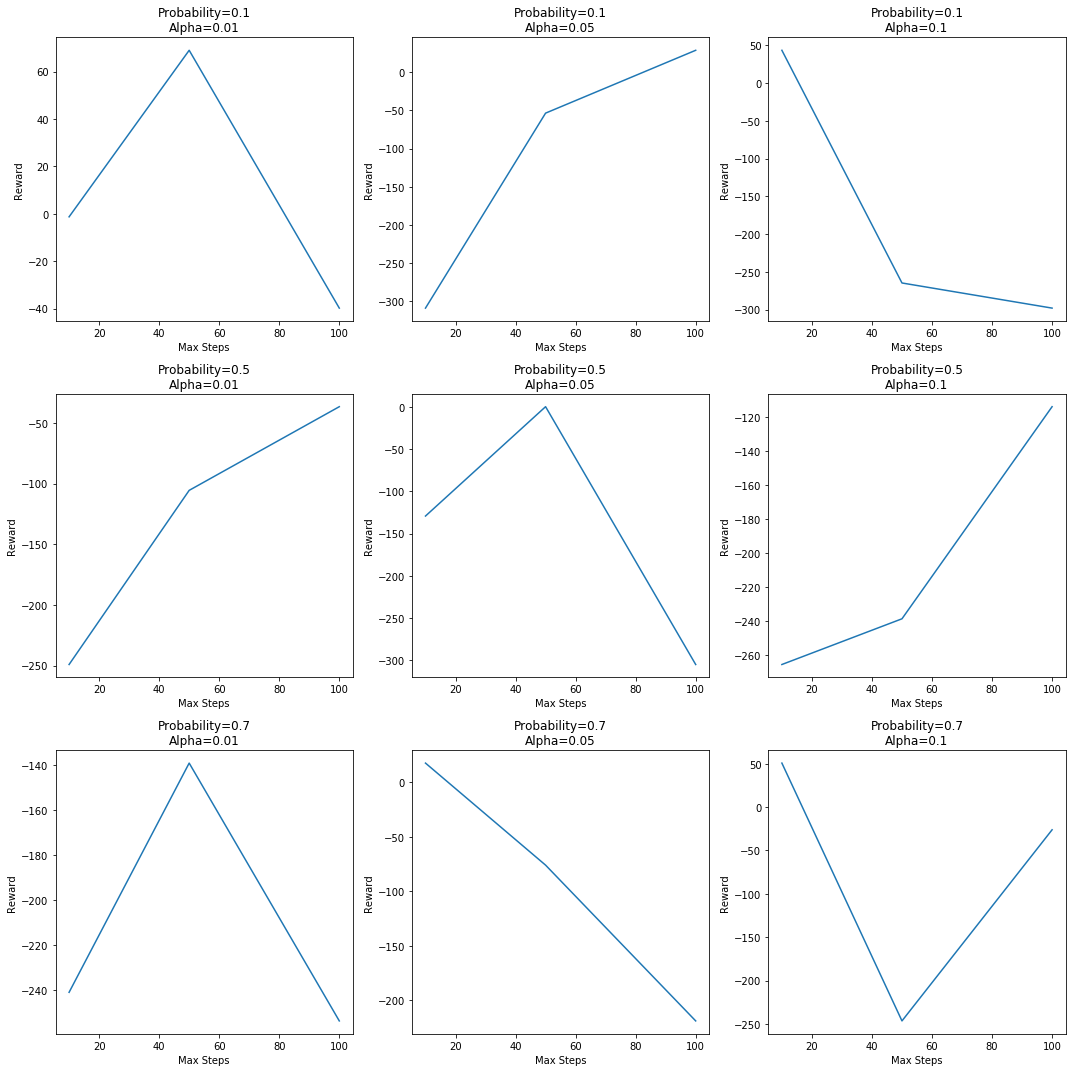

CPU times: user 3h 58min 13s, sys: 1min 36s, total: 3h 59min 50s
Wall time: 3h 59min 25s


In [0]:
%%time
date_start = pd.to_datetime('2019-06-12')
date_end = pd.to_datetime('2019-06-16')

pairs = not_empty_states_train[not_empty_states_train['actions_per_state']==10]
quantity = pairs.shape[0]

MAX_STEPS = [10, 50, 100]
PROBABILITIES = [0.1, 0.5, 0.7]
ALPHAS = [0.01, 0.05, 0.1]

plt.figure(figsize=(15,15))
for i, probability in enumerate(PROBABILITIES):
    for j, alpha in enumerate(ALPHAS):
        plt.subplot2grid((len(PROBABILITIES), len(ALPHAS)), (i, j))
        reward = []
        for k, max_steps in enumerate(MAX_STEPS):
            model = SMART(max_steps=max_steps, alpha=alpha, probability=probability)
            model.load_ss_data(ss_data[(ss_data['curr_date'] >= '2019-05-18') & (ss_data['curr_date'] <= '2019-06-16')])
            model.load_sl_data(sl_data[(sl_data['date_from'] <= '2019-06-16')])
            model.load_demand_data(demand_data_train)
            model.load_pairs_data(pairs)
            state_data, action_data, env_data = model.fit_multiple(quantity=quantity)
            _, _, _, _, new_reward = simulation(state_data, action_data, env_data, quantity, date_start, date_end)
            reward.append(new_reward)
        plt.plot(MAX_STEPS, reward)
        plt.xlabel('Max Steps')
        plt.ylabel('Reward')
        plt.title('Probability=' + str(probability) + '\nAlpha=' + str(alpha))
plt.tight_layout()
plt.show()

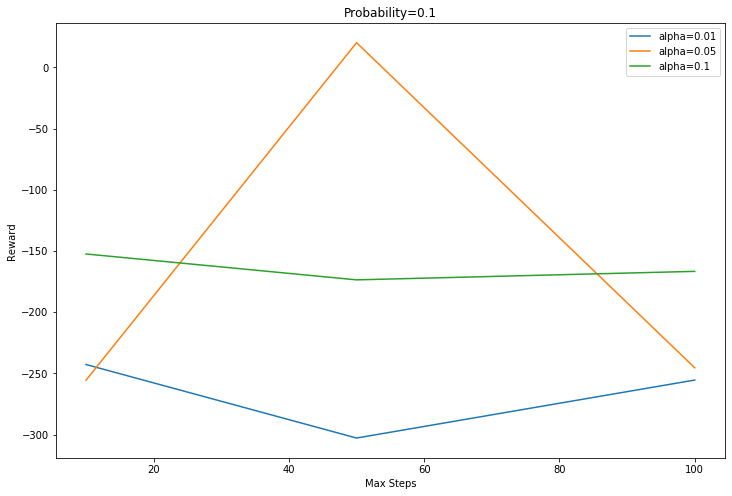

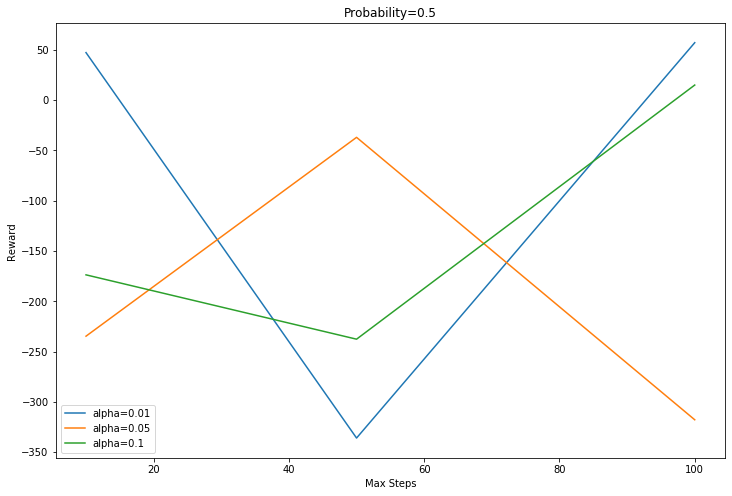

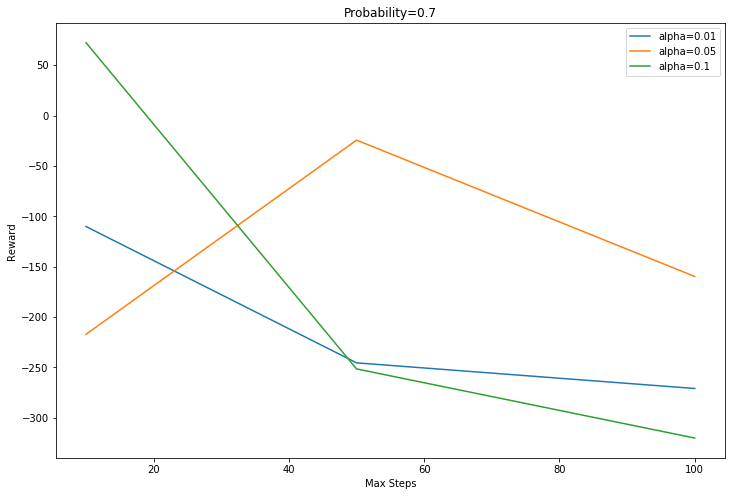

CPU times: user 3h 59min 8s, sys: 1min 39s, total: 4h 48s
Wall time: 4h 24s


In [0]:
%%time
date_start = pd.to_datetime('2019-06-12')
date_end = pd.to_datetime('2019-06-16')

pairs = not_empty_states_train[not_empty_states_train['actions_per_state']==10]
quantity = pairs.shape[0]

MAX_STEPS = [10, 50, 100]
PROBABILITIES = [0.1, 0.5, 0.7]
ALPHAS = [0.01, 0.05, 0.1]

for i, probability in enumerate(PROBABILITIES):
    fig, ax = plt.subplots(figsize=(12,8))
    for j, alpha in enumerate(ALPHAS):
        reward = []
        for k, max_steps in enumerate(MAX_STEPS):
            model = SMART(max_steps=max_steps, alpha=alpha, probability=probability)
            model.load_ss_data(ss_data[(ss_data['curr_date'] >= '2019-05-18') & (ss_data['curr_date'] <= '2019-06-16')])
            model.load_sl_data(sl_data[(sl_data['date_from'] <= '2019-06-16')])
            model.load_demand_data(demand_data_train)
            model.load_pairs_data(pairs)
            state_data, action_data, env_data = model.fit_multiple(quantity=quantity)
            _, _, _, _, new_reward = simulation(state_data, action_data, env_data, quantity, date_start, date_end)
            reward.append(new_reward)
        ax.plot(MAX_STEPS, reward, label='alpha=' + str(alpha))
    ax.set_xlabel('Max Steps')
    ax.set_ylabel('Reward')
    ax.set_title('Probability=' + str(probability))
    ax.legend()
    plt.show()

In [0]:
### Сравнение с Baseline:

In [0]:
%%time
pairs = not_empty_states_train[not_empty_states_train['actions_per_state']==10]
quantity = pairs.shape[0]

model = SMART(max_steps=50, alpha=0.05, probability=0.1)
model.load_ss_data(ss_data)
model.load_sl_data(sl_data)
model.load_demand_data(demand_data_train)
model.load_pairs_data(pairs)

state_data, action_data, env_data = model.fit_multiple(quantity=quantity)

CPU times: user 11min 30s, sys: 16.6 s, total: 11min 47s
Wall time: 11min 49s


In [0]:
%%time
date_start = pd.to_datetime('2019-06-17')
date_end = pd.to_datetime('2019-06-26')
starting_state, old_states, old_reward, new_states, new_reward = simulation(state_data, action_data, env_data, quantity, date_start, date_end)
print(old_reward, new_reward)

-1745.3280994509068 -577.7794486215541
CPU times: user 50.2 s, sys: 13.3 s, total: 1min 3s
Wall time: 1min 3s


In [0]:
starting_state

,location,sku,sales,stock,sl,order,curr_date
0,4600,386400,0,14,0.95,0,2019-06-16
1,4600,416500,0,13,0.95,0,2019-06-16
2,4600,468900,0,2,0.70,0,2019-06-16
3,4600,542000,0,22,0.95,0,2019-06-16
4,4600,559600,0,20,0.95,0,2019-06-16
5,4600,562900,0,8,0.81,0,2019-06-16
6,4600,588500,0,8,0.70,0,2019-06-16
7,4600,613700,3,22,0.70,0,2019-06-16
8,4600,626700,2,8,0.95,0,2019-06-16
9,4600,644700,3,25,0.95,0,2019-06-16


In [0]:
old_states

,location,sku,sales,stock,sl,order,curr_date
0,4600,386400,0,14,0.95,0,2019-06-17
1,4600,386400,0,14,0.95,0,2019-06-18
2,4600,386400,1,14,0.95,0,2019-06-19
3,4600,386400,0,13,0.95,0,2019-06-20
4,4600,386400,0,13,0.95,0,2019-06-21
...,...,...,...,...,...,...,...
395,4600,19816700,1,15,0.95,0,2019-06-22
396,4600,19816700,3,14,0.95,0,2019-06-23
397,4600,19816700,1,11,0.95,0,2019-06-24
398,4600,19816700,2,10,0.95,0,2019-06-25


In [0]:
new_states

,location,sku,sales,stock,sl,order,curr_date
0,4600,386400,2,10,0.95,0,2019-06-17
1,4600,386400,4,6,0.95,0,2019-06-18
2,4600,386400,4,2,0.95,0,2019-06-19
3,4600,386400,2,0,0.95,0,2019-06-20
4,4600,386400,0,0,0.95,0,2019-06-21
...,...,...,...,...,...,...,...
395,4600,19816700,0,0,0.95,0,2019-06-22
396,4600,19816700,0,0,0.95,1,2019-06-23
397,4600,19816700,1,0,0.95,0,2019-06-24
398,4600,19816700,0,0,0.95,0,2019-06-25
